In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re
from copy import deepcopy

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
filename = '../data/20250411_chromatin_dynamics_all_data.h5'
data       = nl.io.load.hdf5(filename)['data']

In [6]:
data.makeSelection(['H2B', 'minflux'])
dt_H2B = data[0].meta['Δt']
print(dt_H2B)
data.makeSelection()

0.00021604399434706808


In [4]:
def msd_for_plotting(dt, tau_e, params, fitname, d=2):
    dummy_fit = bayesmsd.lib.NPFit([np.array([d*[0.]])],
                                   motion_blur_f=tau_e,
                                   parametrization='(log(αΓ), α)')
    for paramname in dummy_fit.parameters:
        if 'log(σ²)' in paramname and '(dim 0)' not in paramname and paramname not in params:
            dummy_fit.parameters[paramname].fix_to = 'log(σ²) (dim 0)'
    params = dummy_fit.fill_dependent_params(params)
    
    msd = dummy_fit.MSD(params, dt)
    if 'minflux' not in fitname:
        return 0.5*msd
    else:
        return msd

def get_params_from_joint_mci(mci, fitname):
    out = {key+' (dim 0)' : m for key, (m, ci) in mci.items() if key in {'α', 'log(αΓ)'}}
    if 'minflux' not in fitname:
        out['log(αΓ) (dim 0)'] += np.log(2) # 2-loc
        
    for key, (m, ci) in mci.items():
        if key.startswith(fitname):
            out[key[(len(fitname)+1):]] = m

    return out

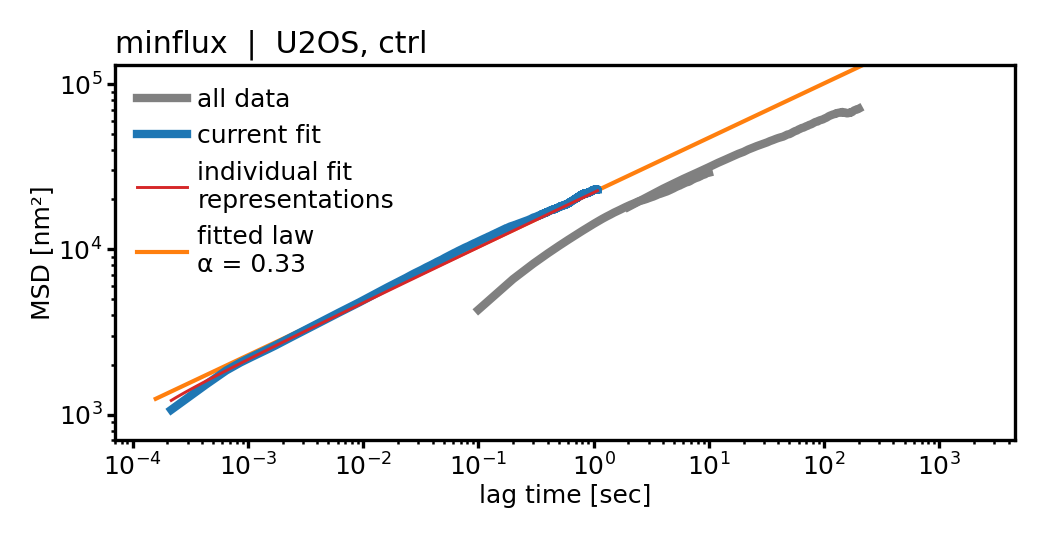

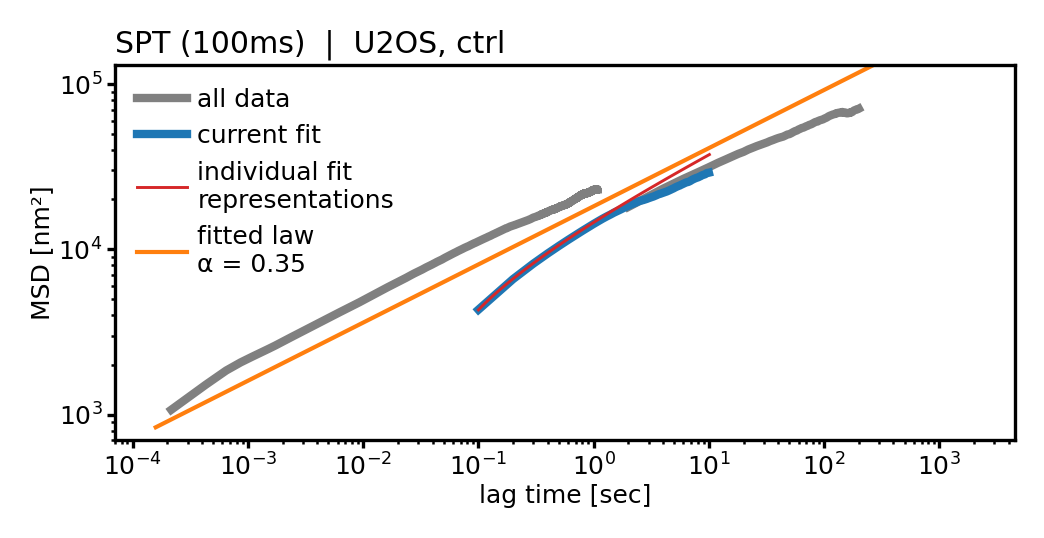

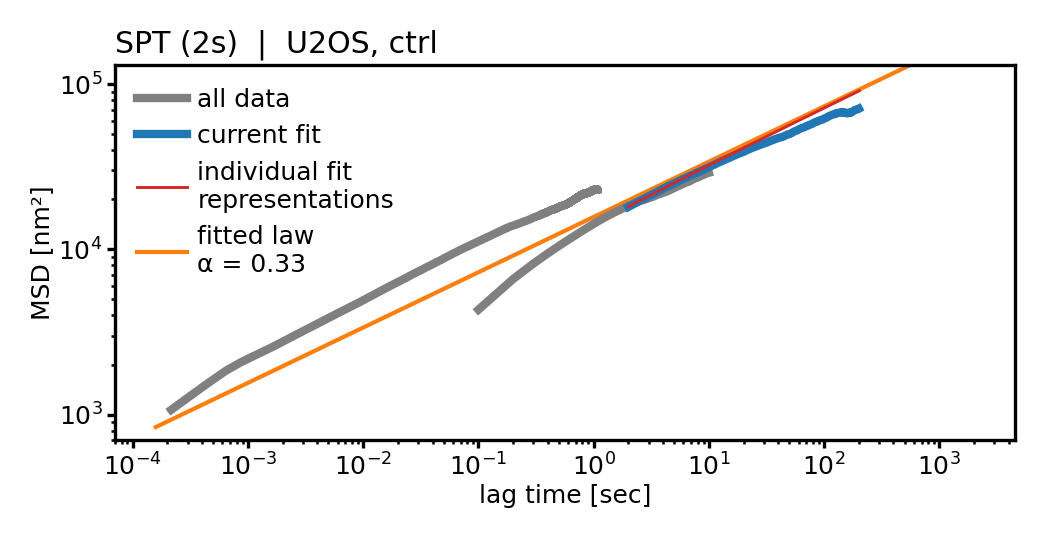

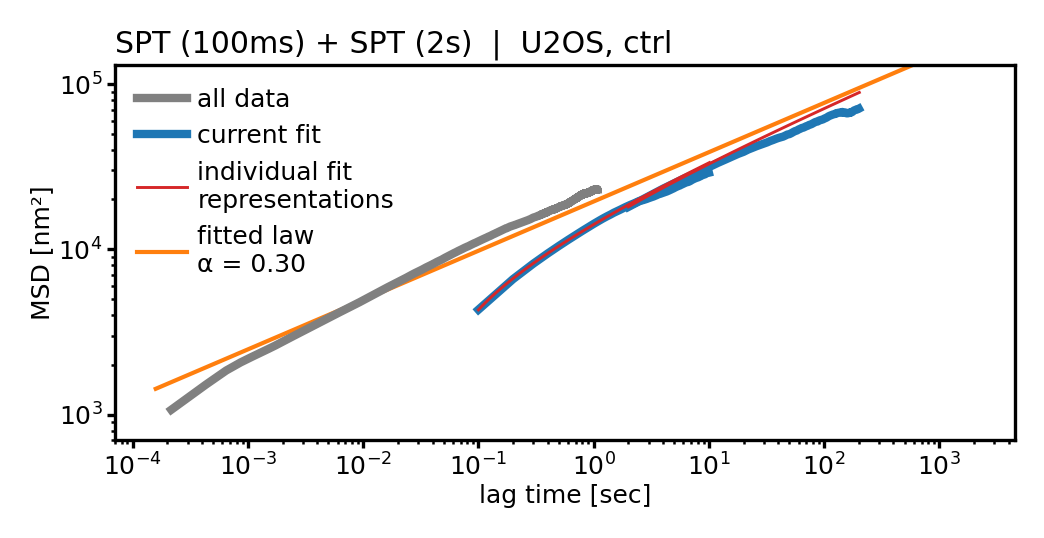

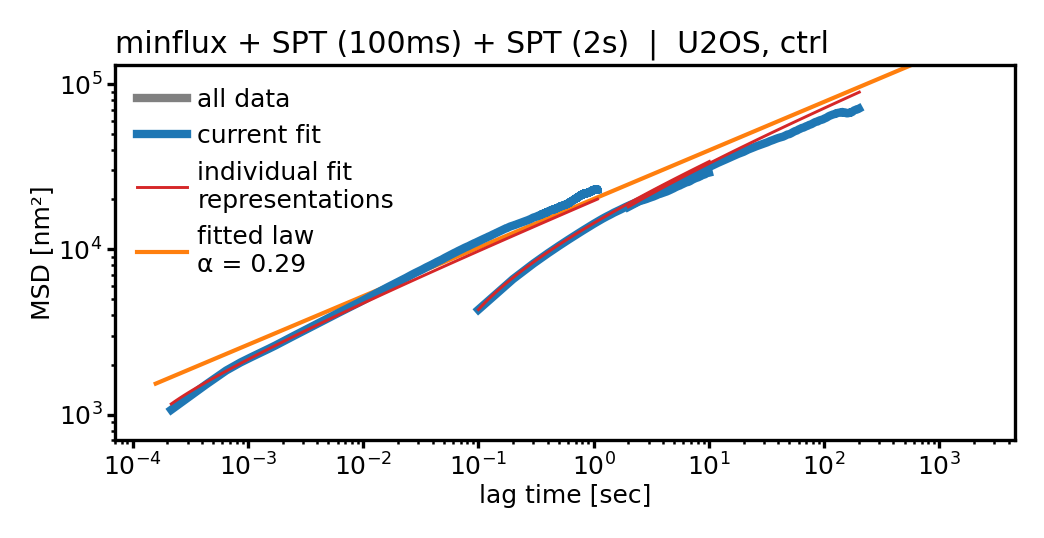

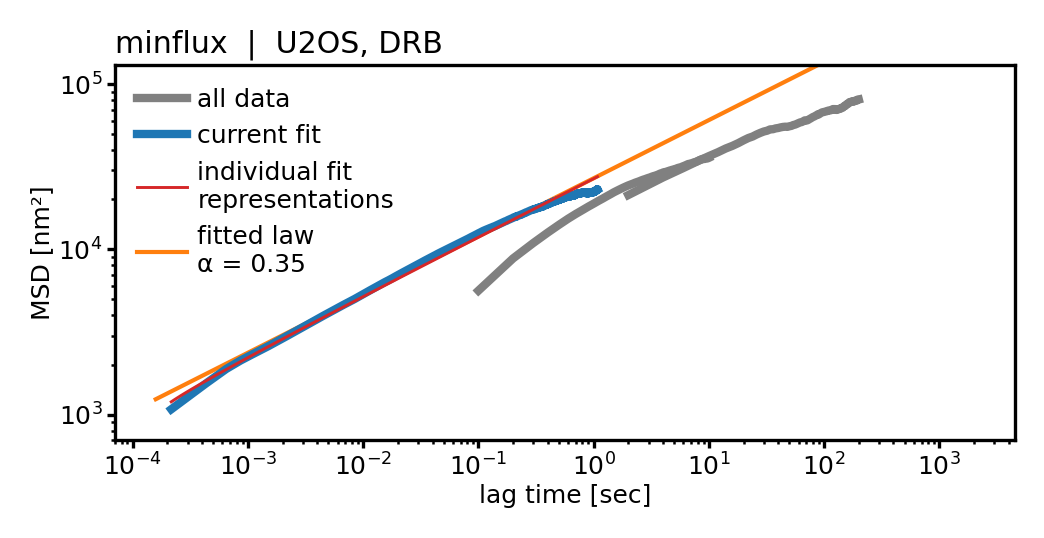

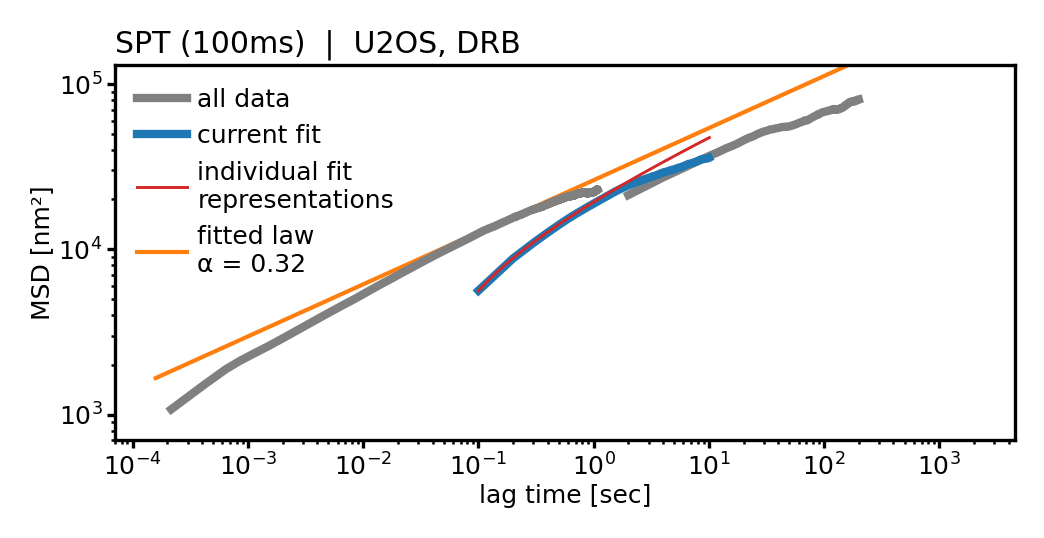

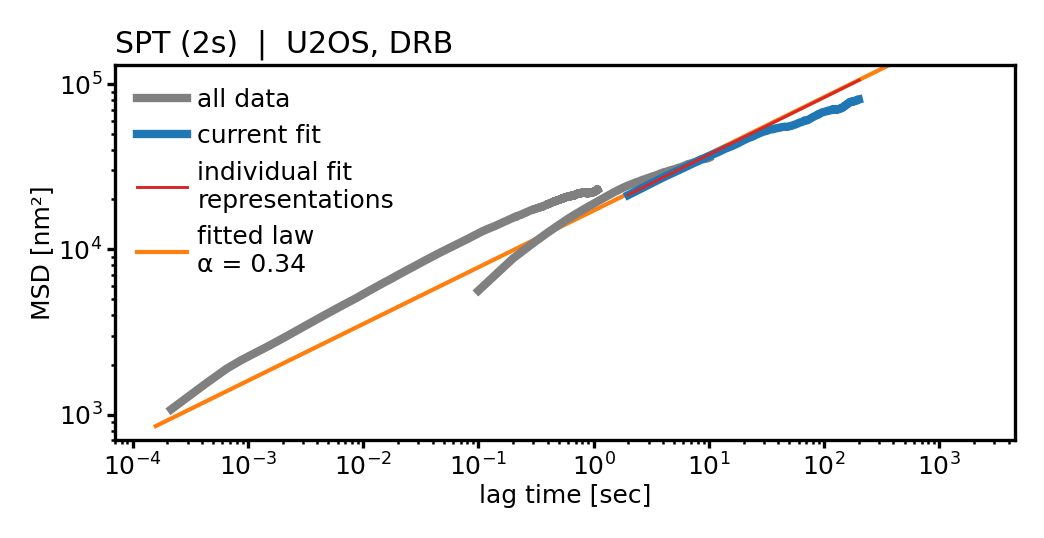

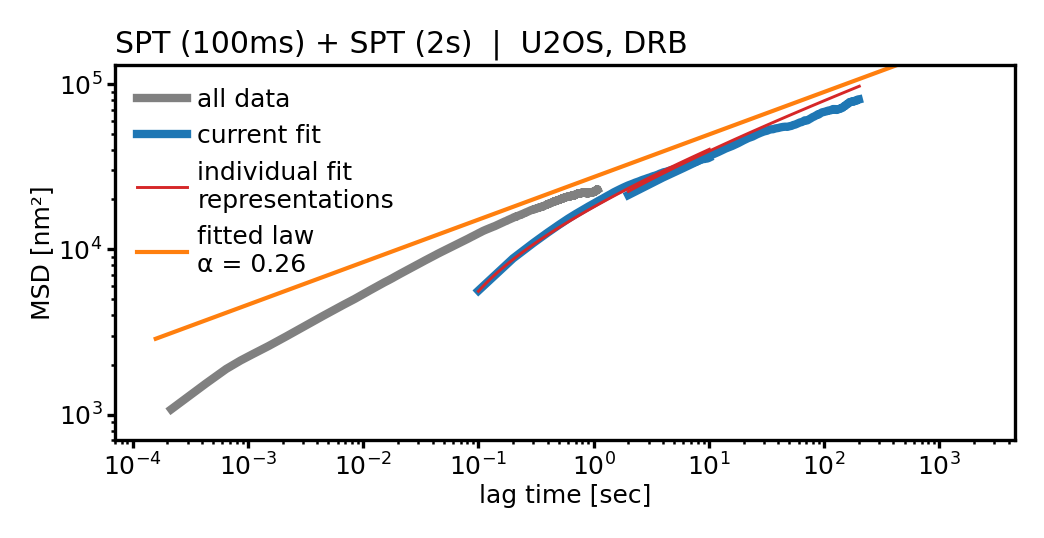

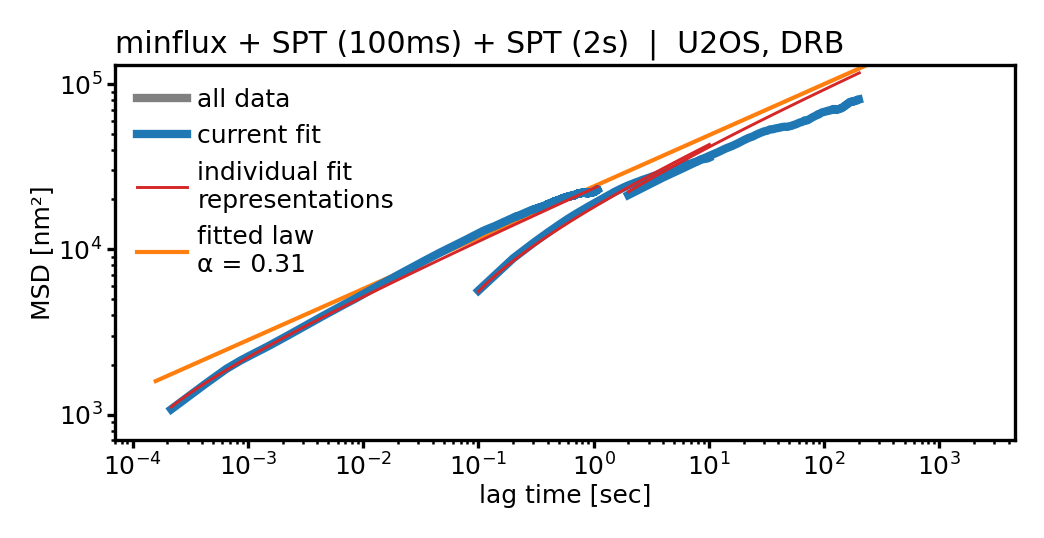

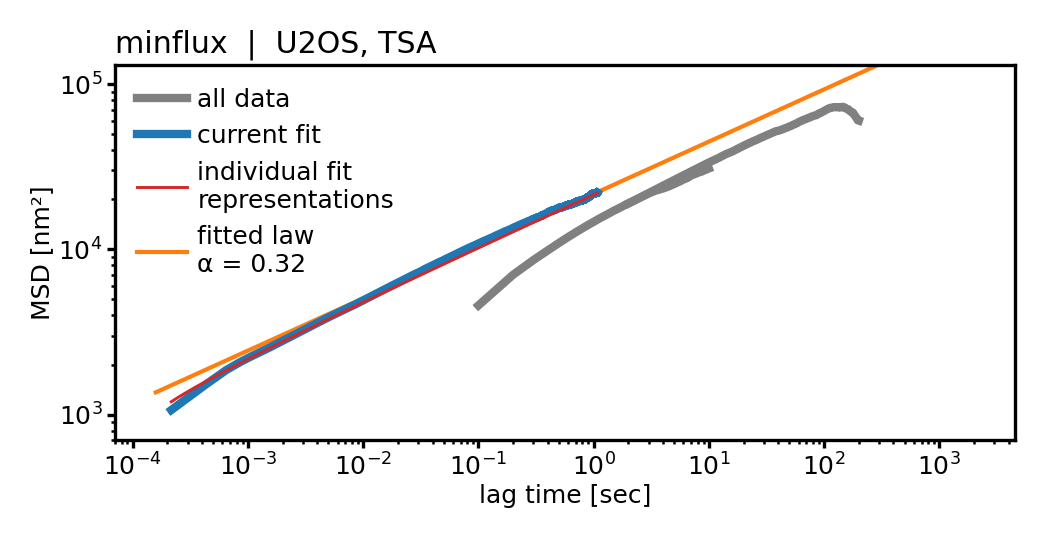

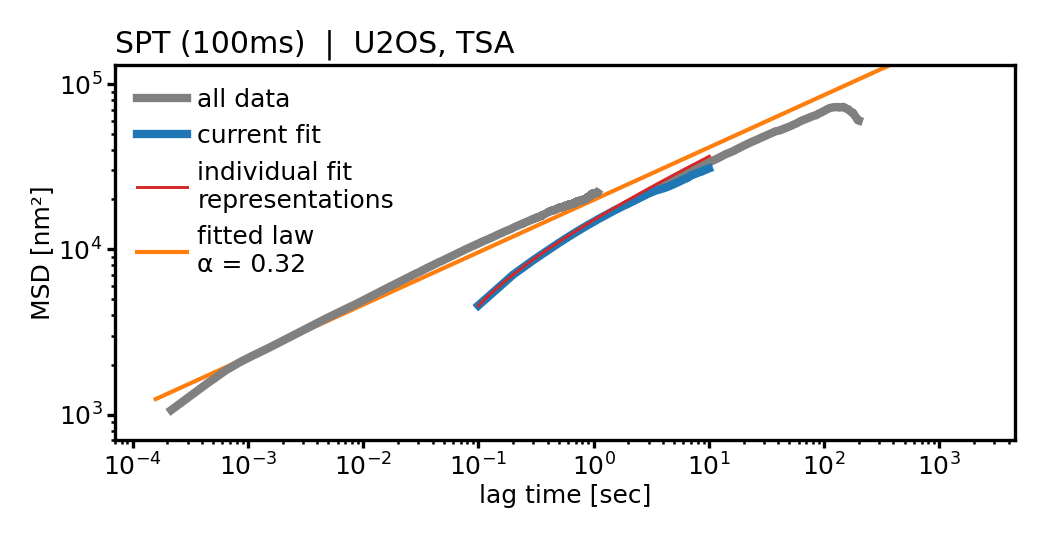

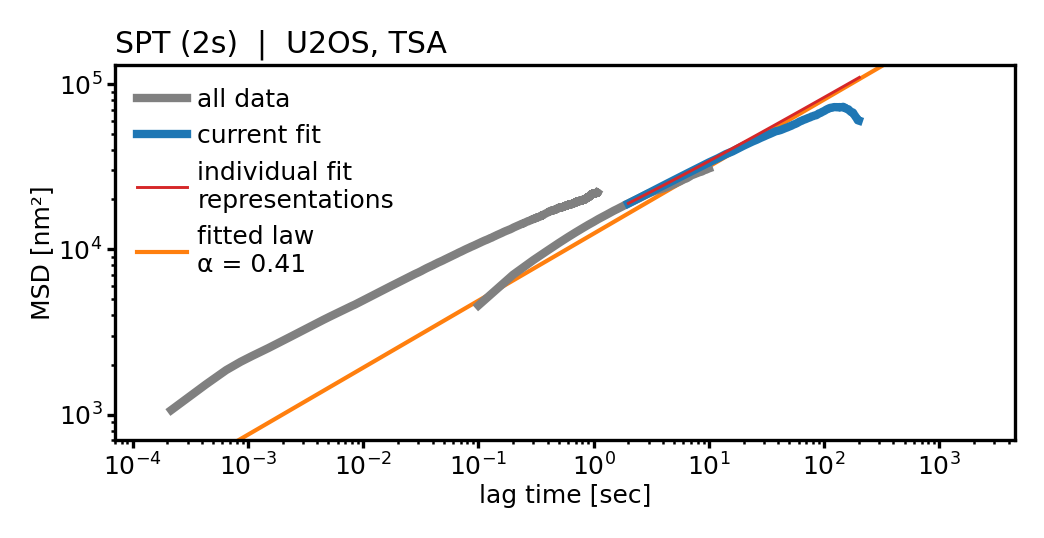

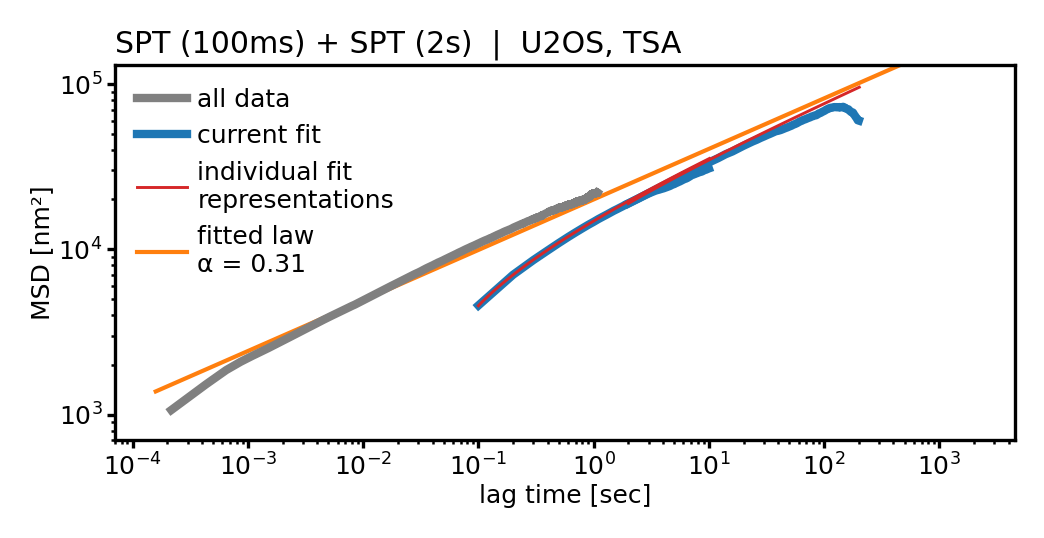

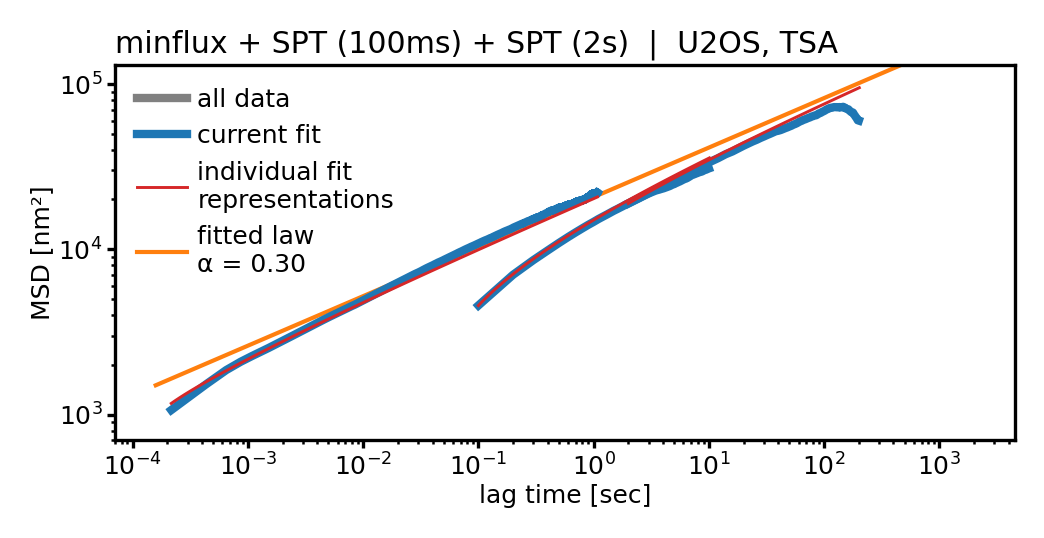

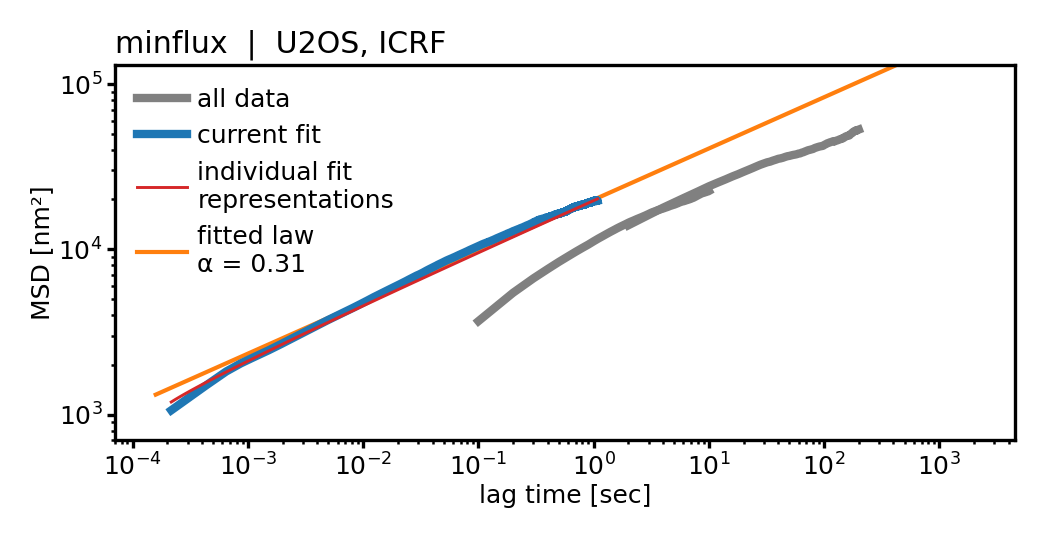

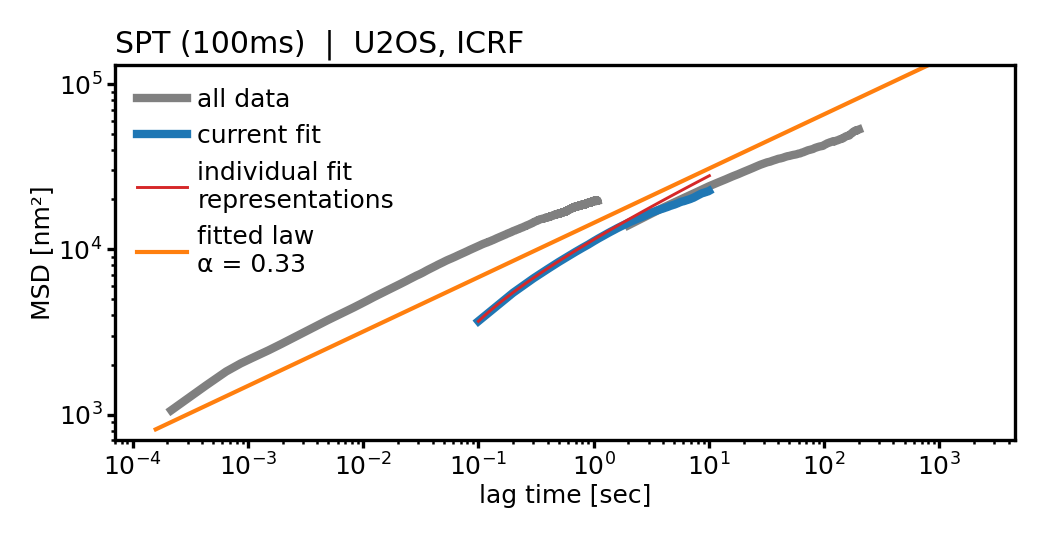

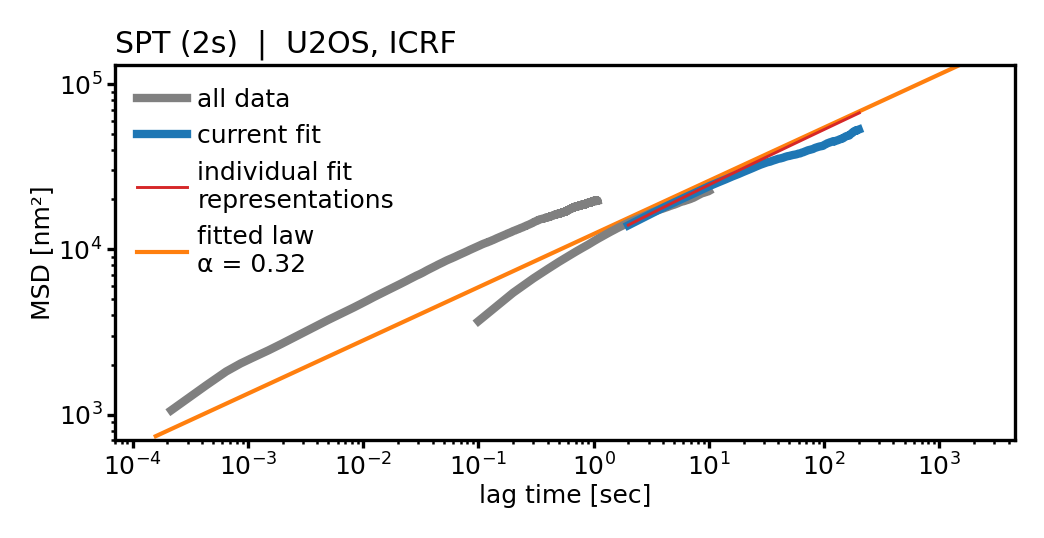

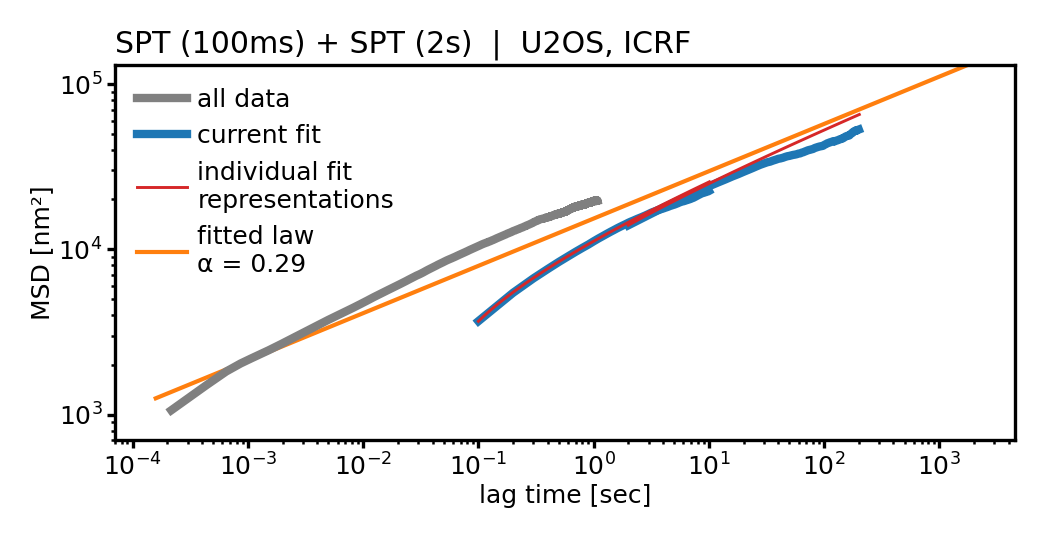

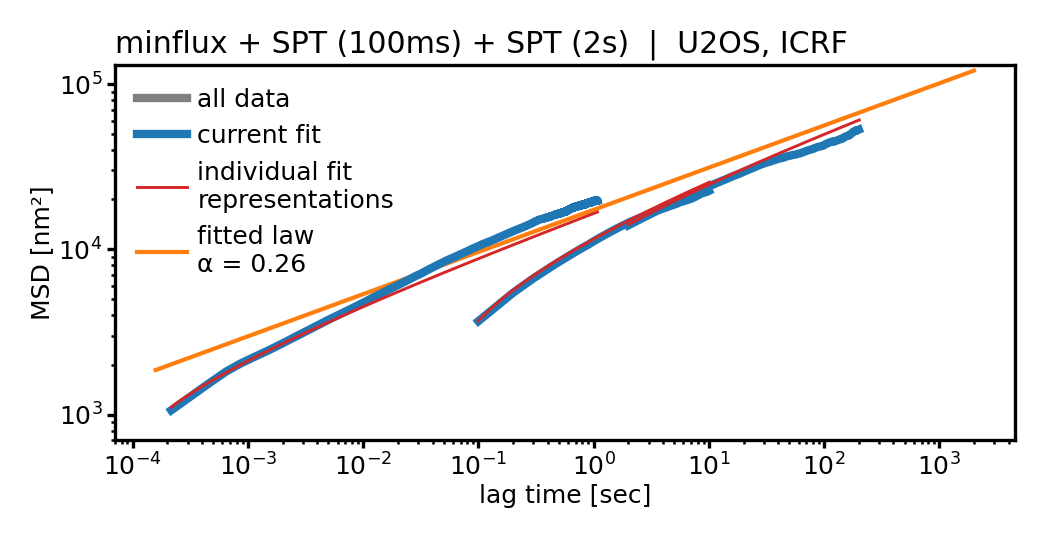

In [8]:
ct = 'U2OS' # set to 'mESC' or 'U2OS'

for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:

    cond = ', '.join(['H2B', ct, treatment])
    mci = nl.io.load.hdf5(f'../data/20250327_mci_NPFit-aGparam_{ct}.h5')[treatment]

    # Assemble list of fit(group)s
    groups = {
        'minflux'       : ['minflux'],
        'SPT 100ms'     : ['SPT-100ms'],
        'SPT 2s'        : ['SPT-2s'],
        'SPT'           : ['SPT-100ms', 'SPT-2s'],
        'minflux + SPT' : ['minflux', 'SPT-100ms', 'SPT-2s'],
    }

    ### Plotting ###

    tmax = {
        'minflux'   : 5001,
        'SPT 100ms' : 101,
        'SPT 2s'    : 101,
    }
    dts = {
        'minflux'   : dt_H2B,
        'SPT 100ms' : 0.1,
        'SPT 2s'    : 2,
    }
    tau_e = {
        'minflux'   : dt_H2B,
        'SPT 100ms' : 0.08761,
        'SPT 2s'    : 0.08761,
    }
    title_dict = {
        'minflux'       : 'minflux',
        'SPT 100ms'     : 'SPT (100ms)',
        'SPT 2s'        : 'SPT (2s)',
        'SPT'           : 'SPT (100ms) + SPT (2s)',
        'minflux + SPT' : 'minflux + SPT (100ms) + SPT (2s)',
    }

    kwargs           = dict(color='gray',       zorder=9,  linewidth=2)
    kwargs_highlight = dict(color='tab:blue',   zorder=10, linewidth=2)
    kwargs_law       = dict(color='tab:orange', zorder=0,  linewidth=1)
    kwargs_repr      = dict(color='tab:red',    zorder=11, linewidth=0.7)

    for i_save, resname in enumerate(title_dict): # preserves order
        fitnames = groups[resname]
        plt.figure(figsize=[6, 2.5])

        # minflux
        kw = kwargs_highlight if any(['minflux' in name for name in fitnames]) else kwargs
        data.makeSelection(['minflux', cond], logic=all)
        dt = data[0].meta['Δt']

        msd = nl.analysis.MSD(data)
        msd *= 1e18 # nm²
        plt.plot(dt*np.arange(1, tmax['minflux']), msd[1:tmax['minflux']], **kw)

        # SPT
        for dt_tag in ['100ms', '2s']:
            kw = kwargs_highlight if 'SPT-'+dt_tag in fitnames else kwargs
            data.makeSelection(['SPT', dt_tag, cond], logic=all)
            dt = data[0].meta['Δt']

            msd = nl.analysis.MSD(data)
            msd /= 2   # 2-loc
            msd *= 1e6 # nm²
            plt.plot(dt*np.arange(1, tmax['SPT '+dt_tag]), msd[1:tmax['SPT '+dt_tag]], **kw)

        # fitres singles
        for fitname in fitnames:
            params = get_params_from_joint_mci(mci[resname], fitname)
            key = fitname.replace('-', ' ')
            xplot = dts[key] * np.logspace(0, np.log10(tmax[key]), 100)
            msd = msd_for_plotting(xplot, tau_e[key], params, fitname)*1e6
            
            plt.plot(xplot, msd, **kwargs_repr)

        # fitres law
        a     = mci[resname]['α'][0]
        logaG = mci[resname]['log(αΓ)'][0]

        G_1D = np.exp(logaG)/a
        G_1D *= 1e6 # nm²

        xplot = np.logspace(-3.8, 3.3, 100)
        plt.plot(xplot, 2*G_1D*xplot**a, **kwargs_law)

        # Plot properties
        plt.plot(0, 0, **kwargs,           label='all data')
        plt.plot(0, 0, **kwargs_highlight, label='current fit')
        plt.plot(0, 0, **kwargs_repr,      label='individual fit\nrepresentations')
        plt.plot(0, 0, **kwargs_law,       label='fitted law\nα = '+f'{a:.2f}')
        plt.legend(loc='upper left')

        plt.title(title_dict[resname]+f'  |  {ct}, {treatment}')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('lag time [sec]')
        plt.ylabel('MSD [nm²]')
        plt.ylim([7e2, 1.3e5])

        # plt.savefig(f'piecewise_fit_plots/{ct}_{treatment}_{i_save}.pdf')
        plt.show()